In [1]:
import os
import random
import time
import typing as ty
import yaml
import argparse
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import models and encoders
os.chdir('/home/mrsergazinov/TabLLM/')
from base_models.mlp import MLP
from base_models.tabTransformer import TabTransformer
from base_models.modernNCA import ModernNCA
from encoders.numEncoders import (
    FourierFeatures, 
    BinningFeatures, 
    ComboFeatures,
    SquareScalingFeatures,
)

from train_eval_adult import preprocess_data, train_and_evaluate_model

MODELS = {
    'MLP': MLP,
    'TabTransformer': TabTransformer,
    'ModernNCA': ModernNCA
}

ENCODERS = {
    'FourierFeatures': FourierFeatures,
    'BinningFeatures': BinningFeatures,
    'ComboFeatures': ComboFeatures,
}

SCALERS = {
    'SquareScalingFeatures': SquareScalingFeatures,
}

In [2]:
def generate_dataset(n, p):
    # generate nxp matrix of features
    X = np.random.randn(n, p)
    
    # Generate alpha coefficients
    alpha = np.random.randn(p) * 0.1

    # Define Gaussian kernel function
    def gaussian_kernel(x1, x2, sigma=0.5):
        return np.exp(-((x1 - x2) ** 2) / sigma)

    # Compute logits
    logits = np.zeros(n)
    for i in range(n):
        for j in range(p):
            kernel_sum = np.sum(gaussian_kernel(X[:, j], X[i, j]))
            logits[i] += alpha[j] * kernel_sum

    # Sample y from Bernoulli distribution with computed logits
    probabilities = 1 / (1 + np.exp(-logits))
    y = np.random.binomial(1, probabilities)

    return X, y

/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 42
Standard MLP: 91.05
FourierFeatures + SquareScalingFeatures: 98.0
FourierFeatures trainable: 97.4
FourierFeatures: 96.7
---------------
Seed: 43
Standard MLP: 100.0
FourierFeatures + SquareScalingFeatures: 100.0
FourierFeatures trainable: 100.0
FourierFeatures: 100.0
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 44
Standard MLP: 99.25
FourierFeatures + SquareScalingFeatures: 99.5
FourierFeatures trainable: 99.45
FourierFeatures: 99.45
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 45
Standard MLP: 90.3
FourierFeatures + SquareScalingFeatures: 98.7
FourierFeatures trainable: 97.6
FourierFeatures: 97.55
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 46
Standard MLP: 92.5
FourierFeatures + SquareScalingFeatures: 98.7
FourierFeatures trainable: 98.4
FourierFeatures: 97.9
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 47
Standard MLP: 90.7
FourierFeatures + SquareScalingFeatures: 98.1
FourierFeatures trainable: 97.95
FourierFeatures: 98.1
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 48
Standard MLP: 88.85
FourierFeatures + SquareScalingFeatures: 98.4
FourierFeatures trainable: 97.05
FourierFeatures: 96.8
---------------
Seed: 49
Standard MLP: 98.3
FourierFeatures + SquareScalingFeatures: 99.3
FourierFeatures trainable: 98.9
FourierFeatures: 98.9
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 50
Standard MLP: 89.25
FourierFeatures + SquareScalingFeatures: 97.4
FourierFeatures trainable: 97.55
FourierFeatures: 96.95
---------------


/tmp/job.573377/ipykernel_419583/3911946877.py:20: RuntimeWarning: overflow encountered in exp
  probabilities = 1 / (1 + np.exp(-logits))


Seed: 51
Standard MLP: 99.05
FourierFeatures + SquareScalingFeatures: 99.35
FourierFeatures trainable: 99.3
FourierFeatures: 99.15
---------------


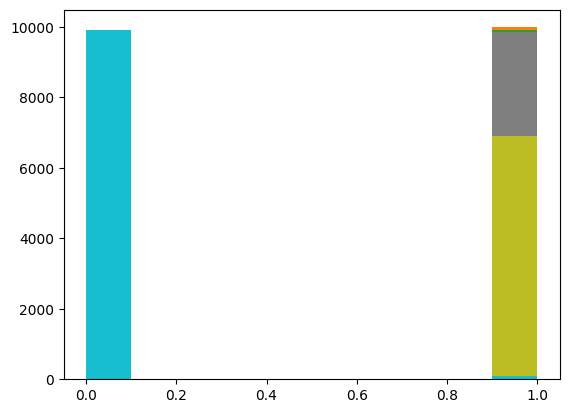

In [ ]:

SEEDS = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

results = defaultdict(list)
for seed in SEEDS:
    torch.manual_seed(seed)
    np.random.seed(seed)
    X, y = generate_dataset(10000, 10)
    params = {
        'model_name': 'MLP',
        'num_encoder': None,
        'num_encoder_trainable': False,
        'scaler': None,
        'n_run': 1,
        'config_file': 'configs/adult.yaml',
        'random_state': seed,
        'test_size': 0.2,
    }
    task_type = 'binary_classification'

    # convet X to DataFrame and y to Series
    X = pd.DataFrame(X)
    y = pd.Series(y)

    print(f"Seed: {seed}")

    y_train, y_test, X_train_num, X_train_cat, X_test_num, X_test_cat = preprocess_data(X, y, task_type, params)
    metric = train_and_evaluate_model(
        X_train_num=X_train_num,
        X_test_num=X_test_num,
        X_train_cat=X_train_cat,
        X_test_cat=X_test_cat,
        y_train=y_train,
        y_test=y_test,
        task_type=task_type,
        params=params,
        verbose_training=False,
        verbose_evaluation=False,
    )
    print(f"Standard MLP: {metric}")
    results['Standard MLP'].append(metric)

    params['num_encoder'] = 'FourierFeatures'
    params['scaler'] = 'SquareScalingFeatures'
    metric = train_and_evaluate_model(
        X_train_num=X_train_num,
        X_test_num=X_test_num,
        X_train_cat=X_train_cat,
        X_test_cat=X_test_cat,
        y_train=y_train,
        y_test=y_test,
        task_type=task_type,
        params=params,
        verbose_training=False,
        verbose_evaluation=False,
    )
    print(f"FourierFeatures + SquareScalingFeatures: {metric}")
    results['FourierFeatures + SquareScalingFeatures'].append(metric)

    params['num_encoder'] = 'FourierFeatures'
    params['num_encoder_trainable'] = True
    params['scaler'] = None
    metric = train_and_evaluate_model(
        X_train_num=X_train_num,
        X_test_num=X_test_num,
        X_train_cat=X_train_cat,
        X_test_cat=X_test_cat,
        y_train=y_train,
        y_test=y_test,
        task_type=task_type,
        params=params,
        verbose_training=False,
        verbose_evaluation=False,
    )
    print(f"FourierFeatures trainable: {metric}")
    results['FourierFeatures_trainable'].append(metric)


    params['num_encoder'] = 'FourierFeatures'
    params['num_encoder_trainable'] = False
    params['scaler'] = None
    metric = train_and_evaluate_model(
        X_train_num=X_train_num,
        X_test_num=X_test_num,
        X_train_cat=X_train_cat,
        X_test_cat=X_test_cat,
        y_train=y_train,
        y_test=y_test,
        task_type=task_type,
        params=params,
        verbose_training=False,
        verbose_evaluation=False,
    )
    print(f"FourierFeatures: {metric}")
    results['FourierFeatures'].append(metric)
    print('-'*15)